## Importing All Required Libraries

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import time
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [29]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [30]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [31]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [32]:
df

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.00,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.00,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.00,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.00,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.00,352,"393,534.00"
...,...,...,...,...,...,...,...,...
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"


In [33]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [34]:
df1 = df.copy()
df1.reset_index(inplace=True)

### Dropping unwanted column

In [35]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)
df

,Date,Open,High,Low,Close,Volume
0,2011-03-20,1200.0,1190.0,1160.0,1170.0,853
1,2011-03-24,1162.0,1178.0,1150.0,1153.0,356
2,2011-03-25,1153.0,1174.0,1145.0,1174.0,702
3,2011-03-27,1174.0,1160.0,1120.0,1147.0,1426
4,2011-03-28,1147.0,1150.0,1110.0,1132.0,352
...,...,...,...,...,...,...
3078,2024-09-18,562.0,565.0,550.0,556.0,68886
3079,2024-09-22,556.0,578.0,556.0,562.0,55026
3080,2024-09-23,573.2,573.2,555.0,568.0,123568
3081,2024-09-24,567.0,567.0,552.1,553.5,66337


### Splitting into features and target

In [37]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [38]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [39]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [40]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

In [41]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

### Splitting the data into train and test set

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

### Model Building using CNN

In [43]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

In [44]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# 4. Train the Model
start = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)
end = time.time()
print('Training Time:', end - start)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0227 - mae: 0.0921 - mse: 0.0227 - val_loss: 0.0031 - val_mae: 0.0375 - val_mse: 0.0031
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - mae: 0.0510 - mse: 0.0055 - val_loss: 0.0018 - val_mae: 0.0270 - val_mse: 0.0018
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0048 - mae: 0.0458 - mse: 0.0048 - val_loss: 0.0013 - val_mae: 0.0245 - val_mse: 0.0013
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - mae: 0.0456 - mse: 0.0047 - val_loss: 0.0036 - val_mae: 0.0429 - val_mse: 0.0036
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - mae: 0.0455 - mse: 0.0044 - val_loss: 0.0013 - val_mae: 0.0244 - val_mse: 0.0013
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - mae: 0.0392 - mse: 0.0036 - val_loss: 8.1443e-04 - val_mae: 0.0187 - val_mse: 8.1443e-04
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0030 - mae: 0.0368 - mse: 0.

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 28, 64)              │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 12, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 4, 128)              │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          12,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 263,153 (1.00 MB)

 Trainable params: 87,717 (342.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 175,436 (685.30 KB)

In [46]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([0.4463071 , 0.64474404, 0.54421496, 0.65678334, 0.10281244,
       0.33548   , 0.5117233 , 0.41925803, 0.591388  , 0.44284832,
       0.4738317 , 0.0750213 , 0.33787593, 0.46925038, 0.6374413 ,
       0.17026173, 0.7776487 , 0.3373611 , 0.17982917, 0.7611924 ,
       0.18106392, 0.10896367, 0.5557748 , 0.4395011 , 0.7224664 ,
       0.18161964, 0.07306574, 0.21750602, 0.40895948, 0.12391348,
       0.8848034 , 0.6126956 , 0.18288833, 0.435548  , 0.60818124,
       0.2191641 , 0.07308826, 0.77301526, 0.18250719, 0.15243475,
       0.25013572, 0.02288899, 0.47841793, 0.14794978, 0.00586864,
       0.14044058, 0.30643108, 0.26759657, 0.35613766, 0.57224876,
       0.1852151 , 0.526439  , 0.43202138, 0.3682469 , 0.54078525,
       0.06861016, 0.04386258, 0.3842459 , 0.25602815, 0.24577078,
       0.6327946 , 0.66501904, 0.39689827, 0.5452638 , 0.17754817,
       0.8786739 , 0.01556829, 0.0704208 , 0.3023537 , 0.37933558,
       0.63766086, 0.62603295, 0.1544516 , 0.43434098, 0.20426

In [47]:
y_test

array([0.45017182, 0.66709622, 0.55841924, 0.70575601, 0.09965636,
       0.3685567 , 0.57689003, 0.43939003, 0.5854811 , 0.45532646,
       0.48281787, 0.07310997, 0.33934708, 0.45446735, 0.67353952,
       0.17310997, 0.79381443, 0.34750859, 0.1911512 , 0.80670103,
       0.1774055 , 0.12628866, 0.5661512 , 0.43685567, 0.73152921,
       0.19802405, 0.09750859, 0.22680412, 0.43513746, 0.14175258,
       0.96993127, 0.62414089, 0.18170103, 0.44158076, 0.62285223,
       0.22379725, 0.08891753, 0.81099656, 0.18213058, 0.14067869,
       0.24699313, 0.0270189 , 0.48883162, 0.14390034, 0.00558419,
       0.12843643, 0.31357388, 0.27405498, 0.36297251, 0.5790378 ,
       0.18427835, 0.53221649, 0.43599656, 0.37457045, 0.54080756,
       0.08118557, 0.04338488, 0.37628866, 0.28264605, 0.24140893,
       0.64561856, 0.64561856, 0.36984536, 0.55541237, 0.19630584,
       0.9871134 , 0.01159794, 0.05992268, 0.29424399, 0.39003436,
       0.66065292, 0.65120275, 0.14304124, 0.43857388, 0.20833

In [48]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [49]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2011-05-11,1070.0,1011.607971
2011-06-02,1056.0,1048.301636
2011-06-14,868.0,976.384521
2011-06-26,1228.0,1096.428711
2011-06-27,1106.0,1158.865723
...,...,...
2024-09-01,595.0,662.911072
2024-09-09,573.0,610.145752
2024-09-11,561.5,585.939575


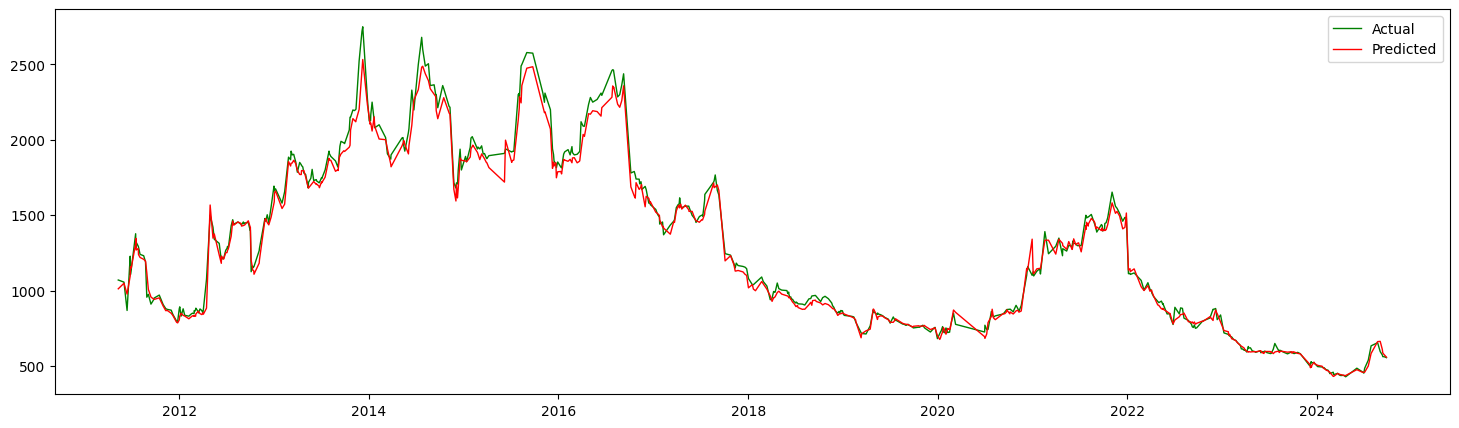

In [50]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()

## Calculating the Performance Evaluation Metrics

In [51]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.0005749924037890172
Root Mean Squared Error: 0.02397899922409226
Mean Absolute Error: 0.016130891553227257


In [52]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 3116.2195402364423
Root Mean Squared Error: 55.823109374491516
Mean Absolute Error: 37.552712967743076
